In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns





# Dataset Path

In [2]:

data_dir = '/content/drive/MyDrive/Tumour/train'
classes = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print("Tumor Classes Found:", classes)


Tumor Classes Found: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


### 1. Understanding the dataset

Count Images in Each Class

glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images


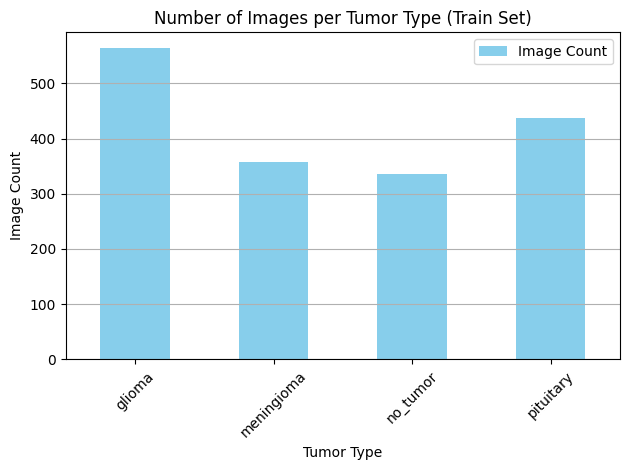

In [3]:
# Counting the images that are in each tumor type folder
image_counts = {}

for cls in classes:
    folder_path = os.path.join(data_dir, cls)
    count = len(os.listdir(folder_path))
    image_counts[cls] = count
    print(f"{cls}: {count} images")

# Visualizing the distribution
df = pd.DataFrame(list(image_counts.items()), columns=['Tumor Type', 'Image Count'])
df.plot(kind='bar', x='Tumor Type', y='Image Count', color='skyblue')
plt.title("Number of Images per Tumor Type (Train Set)")
plt.xlabel("Tumor Type")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Show One Sample Image Per Class

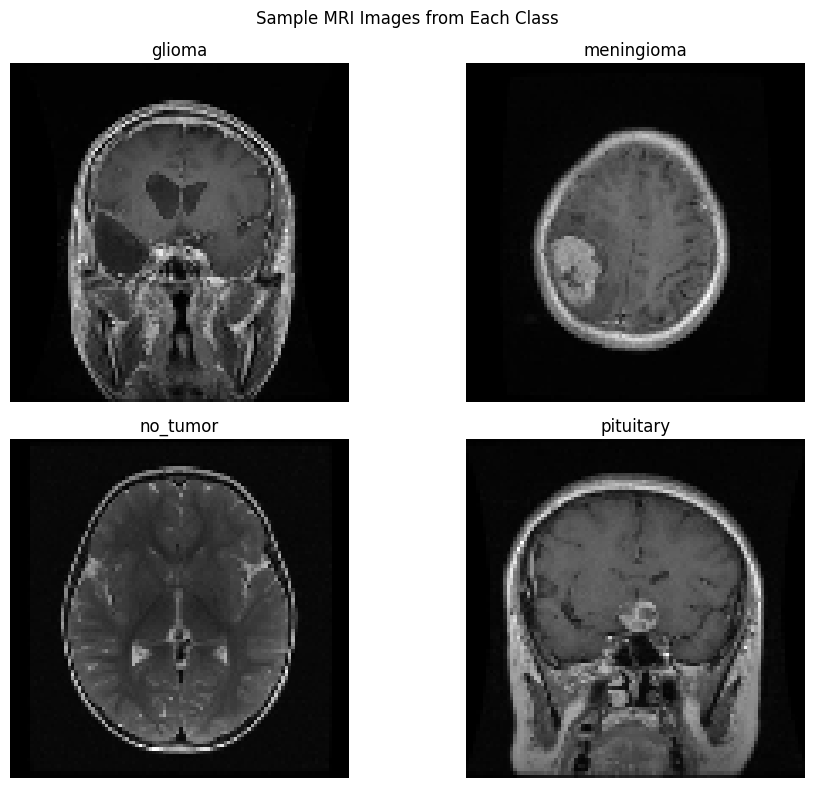

In [4]:
# Display a sample image from each class
img_size = 100

plt.figure(figsize=(10, 8))

for i, cls in enumerate(classes):
    folder_path = os.path.join(data_dir, cls)
    img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample MRI Images from Each Class")
plt.tight_layout()
plt.show()


Check Image Resolution Consistency

In [5]:
# Check image shape consistency across dataset
shapes = []

for cls in classes:
    folder_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder_path)[:10]:  # Just check 10 per class
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        shapes.append(img.shape)

unique_shapes = set(shapes)
print("Unique image resolutions found in the dataset:", unique_shapes)


Unique image resolutions found in the dataset: {(640, 640)}


# Data Preprocessing

Set Preprocessing Configuration

In [6]:
# Set target image size and batch size
image_size = 224
batch_size = 32

# Preprocessing: rescale pixel values to 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


Create Data Generators

In [7]:
# Paths to your image folders
train_path = '/content/drive/MyDrive/Tumour/train'
valid_path = '/content/drive/MyDrive/Tumour/valid'
test_path  = '/content/drive/MyDrive/Tumour/test'

# Load images from folders, resize them, convert to grayscale
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Data Augmentation

Define Augmented Train Generator

In [8]:
# Data augmentation for training set
train_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Validation and test should NOT be augmented
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


Load Images with Augmentation Applied to Train

In [9]:
# Image size and batch size
image_size = 224
batch_size = 32

train_path = '/content/drive/MyDrive/Tumour/train'
valid_path = '/content/drive/MyDrive/Tumour/valid'
test_path  = '/content/drive/MyDrive/Tumour/test'

# Use augmented train generator
train_data = train_augmented.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

# Use normal generator for validation and test
valid_data = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


/tmp/ipython-input-10-1486484083.py:12: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


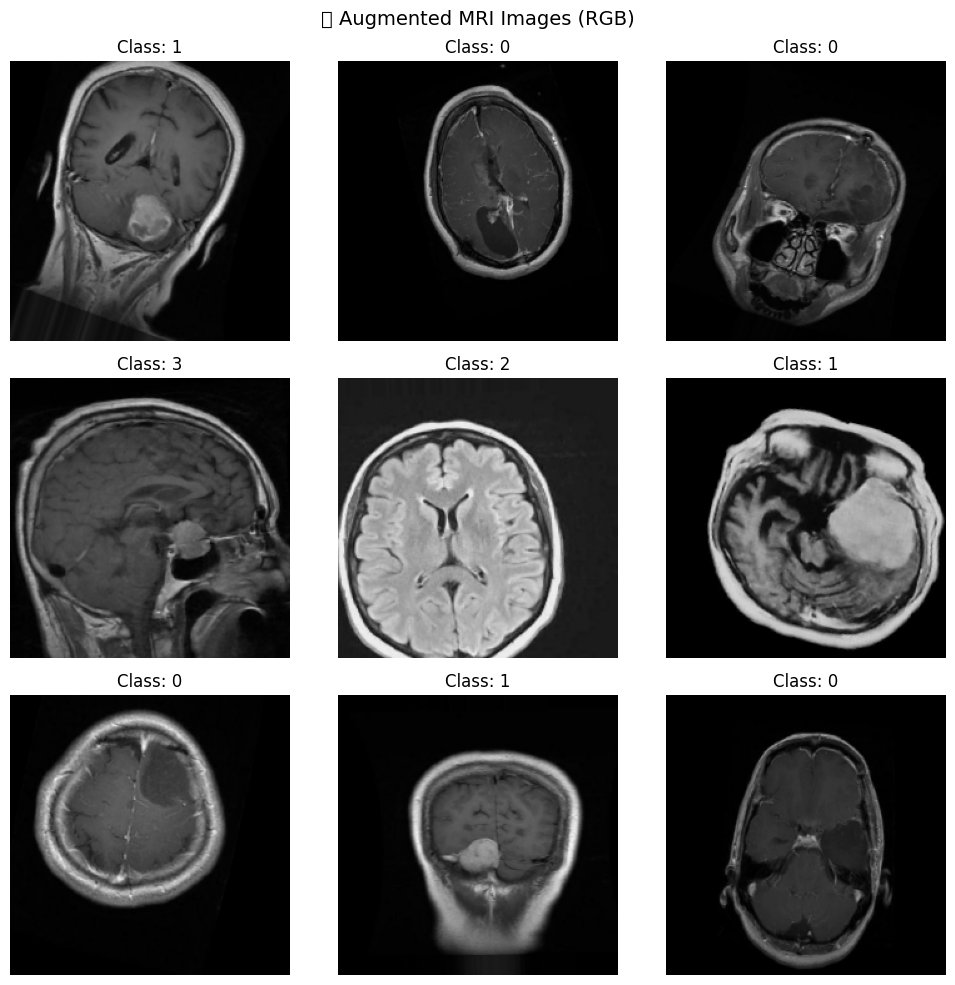

In [10]:
x_batch, y_batch = next(train_data)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])  # No reshape needed for RGB
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis('off')

plt.suptitle("🔁 Augmented MRI Images (RGB)", fontsize=14)
plt.tight_layout()
plt.show()


# Model Building (Custom CNN)

CNN Model

In [18]:

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (4 classes)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary (optional)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Transfer Learning

Load Pretrained Base Model

In [20]:
# Load MobileNetV2 without top layers (include_top=False), use ImageNet weights
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(image_size, image_size, 3))  # NOTE: 3 channels for color

# Freeze the base model for now
base_model.trainable = False


In [21]:
# Create new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 tumor classes

# Combine base + custom layers
model_tl = Model(inputs=base_model.input, outputs=predictions)


In [22]:
model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Fine-Tuning (Unfreeze Top Layers)

In [23]:
# Unfreeze last 20 layers of base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again (required after changing .trainable)
model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])


# Set Up Model Saving Paths

In [24]:
# Save best model for custom CNN
cnn_checkpoint = ModelCheckpoint('best_custom_cnn.h5', monitor='val_loss',
                                  save_best_only=True, verbose=1)

# Save best model for transfer learning
tl_checkpoint = ModelCheckpoint('best_transfer_model.h5', monitor='val_loss',
                                 save_best_only=True, verbose=1)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Training Custom CNN

In [25]:
history_cnn = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop, cnn_checkpoint]
)


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.4500 - loss: 2.9313
Epoch 1: val_loss improved from inf to 7.88388, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 489s 9s/step - accuracy: 0.4506 - loss: 2.9133 - val_accuracy: 0.3207 - val_loss: 7.8839
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5363 - loss: 1.0956
Epoch 2: val_loss did not improve from 7.88388
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 640ms/step - accuracy: 0.5365 - loss: 1.0953 - val_accuracy: 0.3207 - val_loss: 13.1145
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.5448 - loss: 1.0561
Epoch 3: val_loss did not improve from 7.88388
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.5449 - loss: 1.0564 - val_accuracy: 0.3207 - val_loss: 13.7362
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5558 - loss: 1.0728
Epoch 4: val_loss did not improve from 7.88388
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 640ms/step - accuracy: 0.5560 - loss: 1.0725 - val_accuracy: 0.3207 - val_loss: 12.4383


Training Transfer Learning Model

In [26]:
history_tl = model_tl.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop, tl_checkpoint]
)


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.2981 - loss: 1.6314
Epoch 1: val_loss improved from inf to 1.24381, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 885ms/step - accuracy: 0.2992 - loss: 1.6286 - val_accuracy: 0.3964 - val_loss: 1.2438
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5365 - loss: 1.0822
Epoch 2: val_loss improved from 1.24381 to 1.12209, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - accuracy: 0.5373 - loss: 1.0814 - val_accuracy: 0.5020 - val_loss: 1.1221
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6009 - loss: 0.9308
Epoch 3: val_loss improved from 1.12209 to 1.06898, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.6017 - loss: 0.9297 - val_accuracy: 0.5199 - val_loss: 1.0690
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6772 - loss: 0.8077
Epoch 4: val_loss improved from 1.06898 to 1.03015, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 625ms/step - accuracy: 0.6776 - loss: 0.8069 - val_accuracy: 0.5657 - val_loss: 1.0301
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7212 - loss: 0.7372
Epoch 5: val_loss improved from 1.03015 to 0.95591, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - accuracy: 0.7214 - loss: 0.7363 - val_accuracy: 0.6096 - val_loss: 0.9559
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7301 - loss: 0.6709
Epoch 6: val_loss improved from 0.95591 to 0.88846, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 629ms/step - accuracy: 0.7305 - loss: 0.6702 - val_accuracy: 0.6315 - val_loss: 0.8885
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7828 - loss: 0.5530
Epoch 7: val_loss improved from 0.88846 to 0.84209, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.7829 - loss: 0.5530 - val_accuracy: 0.6494 - val_loss: 0.8421
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8026 - loss: 0.5288
Epoch 8: val_loss improved from 0.84209 to 0.79617, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 634ms/step - accuracy: 0.8024 - loss: 0.5288 - val_accuracy: 0.6633 - val_loss: 0.7962
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7886 - loss: 0.5470
Epoch 9: val_loss improved from 0.79617 to 0.72345, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 633ms/step - accuracy: 0.7888 - loss: 0.5467 - val_accuracy: 0.7032 - val_loss: 0.7234
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8075 - loss: 0.5077
Epoch 10: val_loss improved from 0.72345 to 0.71043, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 650ms/step - accuracy: 0.8076 - loss: 0.5073 - val_accuracy: 0.7052 - val_loss: 0.7104
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8348 - loss: 0.4445
Epoch 11: val_loss improved from 0.71043 to 0.68624, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - accuracy: 0.8348 - loss: 0.4446 - val_accuracy: 0.7211 - val_loss: 0.6862
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8323 - loss: 0.4392
Epoch 12: val_loss improved from 0.68624 to 0.62518, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 618ms/step - accuracy: 0.8324 - loss: 0.4391 - val_accuracy: 0.7550 - val_loss: 0.6252
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8531 - loss: 0.4167
Epoch 13: val_loss improved from 0.62518 to 0.61141, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.8532 - loss: 0.4163 - val_accuracy: 0.7570 - val_loss: 0.6114
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8548 - loss: 0.3973
Epoch 14: val_loss improved from 0.61141 to 0.58927, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 624ms/step - accuracy: 0.8547 - loss: 0.3973 - val_accuracy: 0.7649 - val_loss: 0.5893
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8547 - loss: 0.3755
Epoch 15: val_loss improved from 0.58927 to 0.56413, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 673ms/step - accuracy: 0.8548 - loss: 0.3755 - val_accuracy: 0.7869 - val_loss: 0.5641


In [27]:
def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Custom CNN

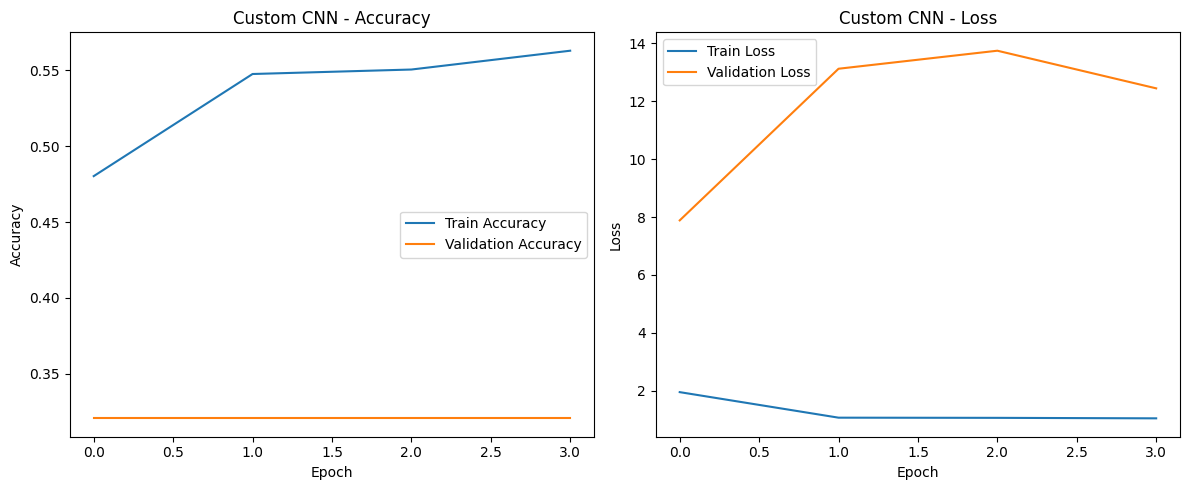

In [28]:
plot_history(history_cnn, "Custom CNN")


MobileNEt

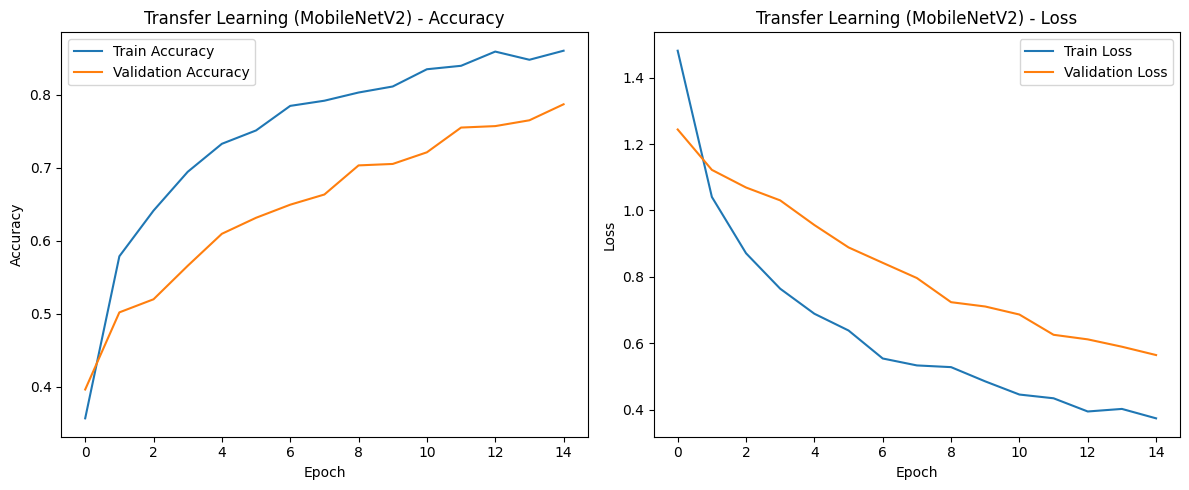

In [29]:
plot_history(history_tl, "Transfer Learning (MobileNetV2)")


# Evaluate Model on Test Data

For Custom CNN

In [31]:
cnn_loss, cnn_acc = model.evaluate(test_data)
print(f"Custom CNN - Test Accuracy: {cnn_acc:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 162s 23s/step - accuracy: 0.5981 - loss: 4.8387
Custom CNN - Test Accuracy: 0.33


 For Transfer Learning

In [32]:
tl_loss, tl_acc = model_tl.evaluate(test_data)
print(f"Transfer Model - Test Accuracy: {tl_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7851 - loss: 0.5032
Transfer Model - Test Accuracy: 0.74


# Classification Report + Confusion Matrix


In [33]:
# True labels
y_true = test_data.classes

# Class labels (optional)
class_labels = list(test_data.class_indices.keys())

# Predict for Custom CNN
y_pred_cnn = model.predict(test_data)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Predict for Transfer Learning model
y_pred_tl = model_tl.predict(test_data)
y_pred_tl_classes = np.argmax(y_pred_tl, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 577ms/step


Classification Report (Precision, Recall, F1)

In [34]:
print("=== Custom CNN ===")
print(classification_report(y_true, y_pred_cnn_classes, target_names=class_labels))

print("\n=== Transfer Learning ===")
print(classification_report(y_true, y_pred_tl_classes, target_names=class_labels))


=== Custom CNN ===
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246


=== Transfer Learning ===
              precision    recall  f1-score   support

      glioma       0.68      0.97      0.80        80
  meningioma       0.72      0.33      0.46        63
    no_tumor       0.94      0.61      0.74        49
   pituitary       0.74      0.96      0.84        54

    accuracy                           0.74       246
   macro avg       0.77      0.72      0.71       246
weighted avg       0.76      0.74      0.71       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix Plot Function

In [35]:
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


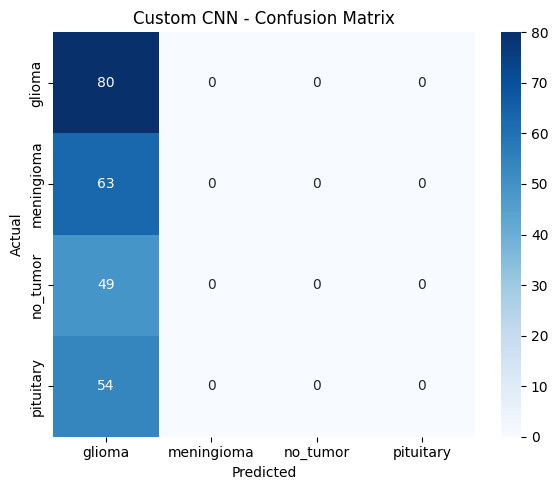

In [36]:
plot_conf_matrix(y_true, y_pred_cnn_classes, class_labels, "Custom CNN - Confusion Matrix")


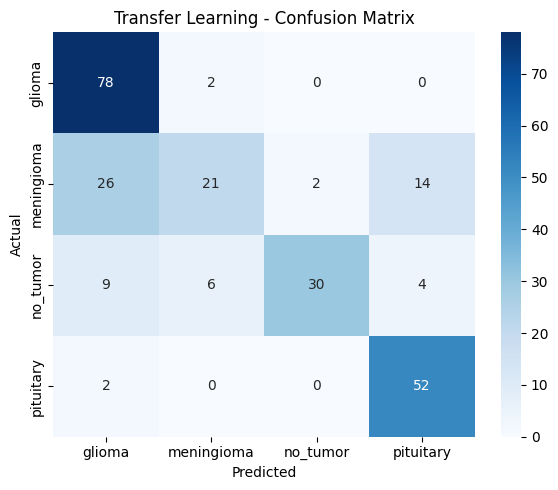

In [37]:
plot_conf_matrix(y_true, y_pred_tl_classes, class_labels, "Transfer Learning - Confusion Matrix")


# Model Comparison

In [38]:
print("📊 Model Accuracy Comparison")
print(f"Custom CNN Accuracy        : {cnn_acc:.4f}")
print(f"Transfer Learning Accuracy : {tl_acc:.4f}")


📊 Model Accuracy Comparison
Custom CNN Accuracy        : 0.3252
Transfer Learning Accuracy : 0.7358


In [39]:

# Transfer
report_tl = classification_report(y_true, y_pred_tl_classes, target_names=class_labels, output_dict=True)
f1_tl = report_tl['weighted avg']['f1-score']

# CNN
report_cnn = classification_report(y_true, y_pred_cnn_classes, target_names=class_labels, output_dict=True)
f1_cnn = report_cnn['weighted avg']['f1-score']

print(f"Weighted F1 Score (CNN)  : {f1_cnn:.4f}")
print(f"Weighted F1 Score (TL)   : {f1_tl:.4f}")


Weighted F1 Score (CNN)  : 0.1596
Weighted F1 Score (TL)   : 0.7087


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
# Save the trained model
model_tl.save("brain_tumor_model.h5")
